In [34]:
import pandas as pd
import numpy as np
import sys
import multiprocessing
import time
import os
import os
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.parser import parse
from pandas.tseries.offsets import BDay
import pickle as pkl
import fnmatch
import pickle
import datetime as dt
from datetime import timedelta
import glob
import fathon
from fathon import fathonUtils as fu
import itertools
import matplotlib as mpl
from scipy.stats import jarque_bera

colormap = plt.cm.RdBu
from scipy.cluster import hierarchy as hc

In [26]:
mpl.get_configdir()
# plot parametrisations
latex_styles = os.listdir(mpl.get_configdir())
latex_styles

plt.style.use(os.path.join(mpl.get_configdir(), latex_styles[0]))
figures_destination = '/home/ak/Research/StylisedFactsPaper/figures'

In [23]:

def df_derived_by_shift(df,lag=0,NON_DER=[]):
    df = df.copy()
    if not lag:
        return df
    cols ={}
    for i in range(1,lag+1):
        for x in list(df.columns):
            if x not in NON_DER:
                if not x in cols:
                    cols[x] = ['{}_{}'.format(x, i)]
                else:
                    cols[x].append('{}_{}'.format(x, i))
    for k,v in cols.items():
        columns = v
        dfn = pd.DataFrame(data=None, columns=columns, index=df.index)    
        i = 1
        for c in columns:
            dfn[c] = df[k].shift(periods=i)
            i+=1
        df = pd.concat([df, dfn], axis=1)
    return df


def get_test_stats(bar_types,bar_returns,test_func,*args,**kwds):
    
    dct = {bar:(int(bar_ret.shape[0]), test_func(bar_ret,*args,**kwds)) 
           for bar,bar_ret in zip(bar_types,bar_returns)}
    df = (pd.DataFrame.from_dict(dct)
          .rename(index={0:'sample_size',1:f'{test_func.__name__}_stat'})
          .T)
    return df

In [19]:
t7 = '/media/ak/T7/August11th2022Experiments'
folders = os.listdir(t7)
returns = os.path.join(t7, 'Returns')
expOne = os.path.join(t7, 'ExperimentOne')
expTwo = os.path.join(t7, 'ExperimentTwo')
mfdfa_dfs = os.path.join(t7, 'mfdfaDataFrames')
ExperimentInputFiles = os.path.join(t7, 'ExperimentInputFiles')
rx1 = os.path.join(ExperimentInputFiles, 'RX1')

In [63]:
rx1_files = os.listdir(rx1)
fileIdx = 100
rx1FileIdxLoc = os.path.join(rx1, rx1_files[fileIdx])
rx1FileIdxLoc

'/media/ak/T7/August11th2022Experiments/ExperimentInputFiles/RX1/RX1_volume_20180618_exp_df.pkl'

In [64]:
df = pd.read_pickle(rx1FileIdxLoc)
df_select = df[['price_imbalance', 'weighted_activity_spread', 'GK_vol', 'arrival_rates',
       'returns_normalised','median_traded_volume']]

In [65]:
df_select

,price_imbalance,weighted_activity_spread,GK_vol,arrival_rates,returns_normalised,median_traded_volume
0,64.050295,0.010065,0.000051,3.0,0.000000,3.0
1,6.957308,0.011140,0.000048,1.0,-1.303024,22.0
2,-9.031944,0.010000,0.000046,1.0,0.051699,43.0
3,0.005000,0.010000,0.000052,2.0,0.049145,43.0
4,11.482579,0.010000,0.000052,1.0,0.023738,43.0
...,...,...,...,...,...,...
1286017,6.275584,0.016432,0.000000,0.0,0.592106,8.0
1286018,108.325254,0.010000,0.000000,0.0,0.951439,9.0
1286019,47.063342,0.010000,0.000000,0.0,-0.386807,6.5
1286020,-11.269413,0.010000,0.000000,0.0,-0.123175,2.5


In [66]:

df_shifted =df_derived_by_shift(df_select, 1)

In [67]:
sns.set_context("paper", rc={"font.size":54,"axes.titlesize":26,"axes.labelsize":20}) 

In [68]:
sns.set(rc={'figure.figsize':(22,15)})
mask = np.zeros_like(df_shifted.corr())
mask[np.triu_indices_from(mask)] = True

In [86]:
df_shifted.corr()

,price_imbalance,weighted_activity_spread,GK_vol,arrival_rates,returns_normalised,median_traded_volume,price_imbalance_1,weighted_activity_spread_1,GK_vol_1,arrival_rates_1,returns_normalised_1,median_traded_volume_1
price_imbalance,1.000000,0.034511,-0.060728,0.030156,0.051311,0.035126,0.860058,0.037586,-0.060790,0.029790,0.102921,0.038068
weighted_activity_spread,0.034511,1.000000,0.063383,-0.018003,-0.020523,-0.048109,0.043872,0.407319,0.063588,-0.018360,-0.004957,-0.041888
GK_vol,-0.060728,0.063383,1.000000,-0.052652,-0.001102,-0.110254,-0.060449,0.062433,0.984268,-0.052595,-0.001204,-0.108456
arrival_rates,0.030156,-0.018003,-0.052652,1.000000,-0.000496,0.048200,0.030417,-0.018204,-0.052716,0.758832,-0.000354,0.047928
returns_normalised,0.051311,-0.020523,-0.001102,-0.000496,1.000000,0.001699,-0.103843,-0.162401,-0.000637,-0.000755,-0.051561,0.002311
median_traded_volume,0.035126,-0.048109,-0.110254,0.048200,0.001699,1.000000,0.034634,-0.038915,-0.111989,0.048295,-0.000162,0.966303
price_imbalance_1,0.860058,0.043872,-0.060449,0.030417,-0.103843,0.034634,1.000000,0.034511,-0.060728,0.030156,0.051311,0.035125
weighted_activity_spread_1,0.037586,0.407319,0.062433,-0.018204,-0.162401,-0.038915,0.034511,1.000000,0.063383,-0.018003,-0.020523,-0.048109
GK_vol_1,-0.060790,0.063588,0.984268,-0.052716,-0.000637,-0.111989,-0.060728,0.063383,1.000000,-0.052652,-0.001102,-0.110254
arrival_rates_1,0.029790,-0.018360,-0.052595,0.758832,-0.000755,0.048295,0.030156,-0.018003,-0.052652,1.000000,-0.000496,0.048200


In [85]:
svm = sns.heatmap(df_shifted.corr(), mask=mask)
# file_name = 'cross_correlation_two.png'
# plt.savefig(os.path.join(figures_destination,file_name))
# plt.legend()
plt.show()

RuntimeError: latex was not able to process the following string:
b'price_imbalance'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/home/ak/.cache/matplotlib/tex.cache/d315b02296fc04c754f7a26622693162.tex
LaTeX2e <2017-04-15>
Babel <3.18> and hyphenation patterns for 5 language(s) loaded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/utf8.def
(/usr/share/texlive/texmf-dist/tex/latex/base/t1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/ot1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/omsenc.dfu)))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (/usr/share/texlive/texmf-dist/tex/latex/amsfonts/amssymb.sty
(/usr/share/texlive/texmf-dist/tex/latex/amsfonts/amsfonts.sty))
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.def
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.dfu)))
(./d315b02296fc04c754f7a26622693162.aux)
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.19 {\sffamily price_
                      imbalance}
No pages of output.
Transcript written on d315b02296fc04c754f7a26622693162.log.




RuntimeError: latex was not able to process the following string:
b'price_imbalance'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/home/ak/.cache/matplotlib/tex.cache/d315b02296fc04c754f7a26622693162.tex
LaTeX2e <2017-04-15>
Babel <3.18> and hyphenation patterns for 5 language(s) loaded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/utf8.def
(/usr/share/texlive/texmf-dist/tex/latex/base/t1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/ot1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/omsenc.dfu)))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (/usr/share/texlive/texmf-dist/tex/latex/amsfonts/amssymb.sty
(/usr/share/texlive/texmf-dist/tex/latex/amsfonts/amsfonts.sty))
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.def
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.dfu)))
(./d315b02296fc04c754f7a26622693162.aux)
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.19 {\sffamily price_
                      imbalance}
No pages of output.
Transcript written on d315b02296fc04c754f7a26622693162.log.




<Figure size 1584x1080 with 2 Axes>

In [70]:
df_shifted.corr().dropna()

,price_imbalance,weighted_activity_spread,GK_vol,arrival_rates,returns_normalised,median_traded_volume,price_imbalance_1,weighted_activity_spread_1,GK_vol_1,arrival_rates_1,returns_normalised_1,median_traded_volume_1
price_imbalance,1.000000,0.034511,-0.060728,0.030156,0.051311,0.035126,0.860058,0.037586,-0.060790,0.029790,0.102921,0.038068
weighted_activity_spread,0.034511,1.000000,0.063383,-0.018003,-0.020523,-0.048109,0.043872,0.407319,0.063588,-0.018360,-0.004957,-0.041888
GK_vol,-0.060728,0.063383,1.000000,-0.052652,-0.001102,-0.110254,-0.060449,0.062433,0.984268,-0.052595,-0.001204,-0.108456
arrival_rates,0.030156,-0.018003,-0.052652,1.000000,-0.000496,0.048200,0.030417,-0.018204,-0.052716,0.758832,-0.000354,0.047928
returns_normalised,0.051311,-0.020523,-0.001102,-0.000496,1.000000,0.001699,-0.103843,-0.162401,-0.000637,-0.000755,-0.051561,0.002311
median_traded_volume,0.035126,-0.048109,-0.110254,0.048200,0.001699,1.000000,0.034634,-0.038915,-0.111989,0.048295,-0.000162,0.966303
price_imbalance_1,0.860058,0.043872,-0.060449,0.030417,-0.103843,0.034634,1.000000,0.034511,-0.060728,0.030156,0.051311,0.035125
weighted_activity_spread_1,0.037586,0.407319,0.062433,-0.018204,-0.162401,-0.038915,0.034511,1.000000,0.063383,-0.018003,-0.020523,-0.048109
GK_vol_1,-0.060790,0.063588,0.984268,-0.052716,-0.000637,-0.111989,-0.060728,0.063383,1.000000,-0.052652,-0.001102,-0.110254
arrival_rates_1,0.029790,-0.018360,-0.052595,0.758832,-0.000755,0.048295,0.030156,-0.018003,-0.052652,1.000000,-0.000496,0.048200


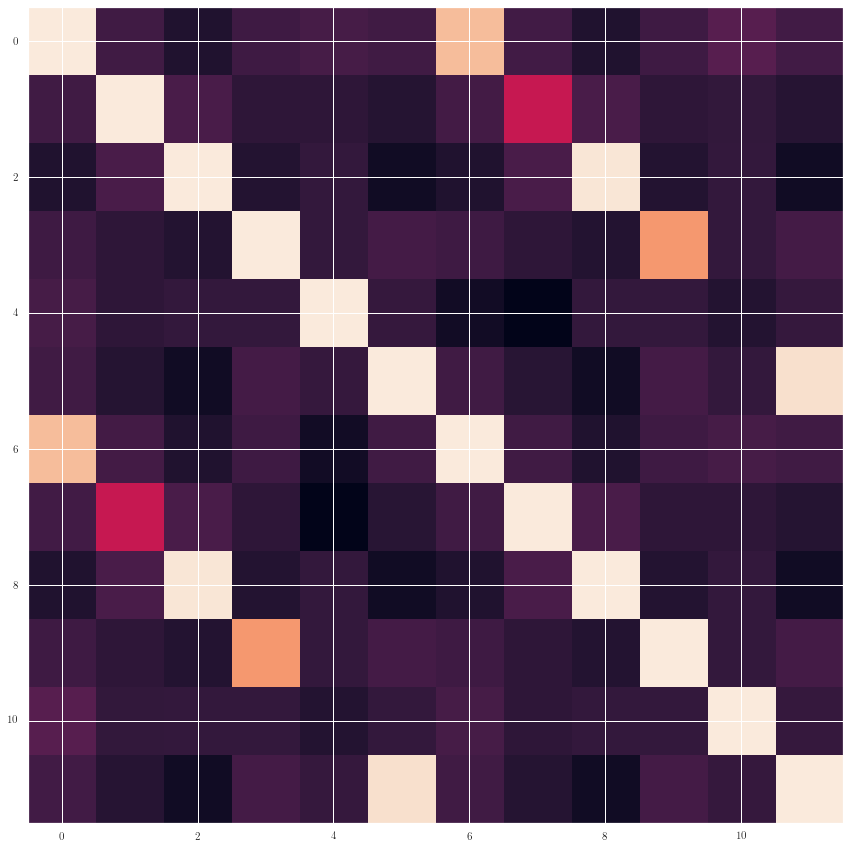

In [71]:
correl = df_shifted.corr().fillna(0)
fig, ax = plt.subplots()
im = ax.imshow(correl)

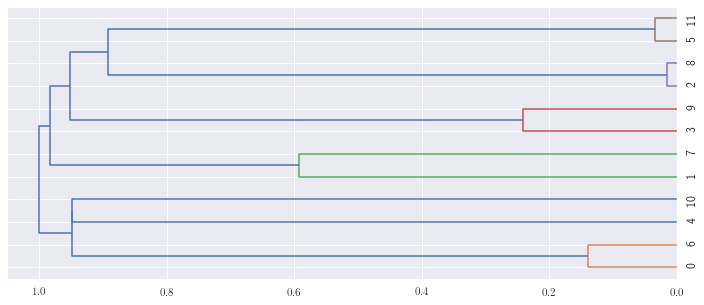

In [84]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

plt.figure(figsize=(12,5))
dissimilarity = 1 - abs(correl)
Z = linkage(squareform(dissimilarity), 'complete')

dendrogram(Z,  orientation='left', 
           leaf_rotation=90);



In [81]:
correl.columns

Index(['price_imbalance', 'weighted_activity_spread', 'GK_vol',
       'arrival_rates', 'returns_normalised', 'median_traded_volume',
       'price_imbalance_1', 'weighted_activity_spread_1', 'GK_vol_1',
       'arrival_rates_1', 'returns_normalised_1', 'median_traded_volume_1'],
      dtype='object')